# Test Dataloader

In [1]:
from utils.data import build_dataset,build_xview_dataset, unwrap_collate_fn
from attrdict import AttrDict
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from utils.fcos import fcos_resnet50_fpn
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TRAIN_DATA_DIR='determined-ai-xview-coco-dataset/val_sliced_no_neg/val_images_300_02/'

dataset, num_classes = build_xview_dataset(image_set='val',args=AttrDict({
                                                'data_dir':TRAIN_DATA_DIR,
                                                'backend':'aws',
                                                'masks': None,
                                                }))

PATHS:  {'train': ('determined-ai-xview-coco-dataset/val_sliced_no_neg/val_images_300_02/', '/tmp/train_sliced_no_neg/train_300_02_1k.json'), 'val': ('determined-ai-xview-coco-dataset/val_sliced_no_neg/val_images_300_02/', '/tmp/val_sliced_no_neg/val_300_02_1k.json')}
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
self.catIdtoCls:  {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 17: 18, 18: 19, 19: 20, 20: 21, 21: 22, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50, 50: 51, 51: 52, 52: 53, 53: 54, 54: 55, 55: 56, 56: 57, 57: 58, 58: 59, 59: 60}


In [3]:
dataset[0]

(tensor([[[0.3490, 0.3451, 0.3255,  ..., 0.3569, 0.3412, 0.3255],
          [0.3255, 0.3294, 0.3490,  ..., 0.3686, 0.3569, 0.3490],
          [0.3333, 0.3216, 0.3490,  ..., 0.3608, 0.3529, 0.3529],
          ...,
          [0.1490, 0.1647, 0.1608,  ..., 0.1647, 0.1451, 0.0980],
          [0.1490, 0.1647, 0.1608,  ..., 0.2353, 0.1294, 0.1255],
          [0.1490, 0.1647, 0.1608,  ..., 0.2471, 0.0784, 0.1569]],
 
         [[0.3098, 0.3059, 0.2863,  ..., 0.2667, 0.2549, 0.2392],
          [0.2863, 0.2902, 0.3098,  ..., 0.2784, 0.2706, 0.2627],
          [0.2941, 0.2824, 0.3098,  ..., 0.2667, 0.2667, 0.2667],
          ...,
          [0.1294, 0.1451, 0.1294,  ..., 0.1412, 0.1294, 0.0824],
          [0.1294, 0.1451, 0.1294,  ..., 0.2118, 0.1137, 0.1098],
          [0.1294, 0.1451, 0.1294,  ..., 0.2235, 0.0627, 0.1412]],
 
         [[0.2627, 0.2588, 0.2471,  ..., 0.2118, 0.2000, 0.1843],
          [0.2392, 0.2431, 0.2706,  ..., 0.2235, 0.2157, 0.2078],
          [0.2471, 0.2353, 0.2706,  ...,

In [4]:
{i:i+1 for i in dataset.coco.getCatIds()}

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 27,
 27: 28,
 28: 29,
 29: 30,
 30: 31,
 31: 32,
 32: 33,
 33: 34,
 34: 35,
 35: 36,
 36: 37,
 37: 38,
 38: 39,
 39: 40,
 40: 41,
 41: 42,
 42: 43,
 43: 44,
 44: 45,
 45: 46,
 46: 47,
 47: 48,
 48: 49,
 49: 50,
 50: 51,
 51: 52,
 52: 53,
 53: 54,
 54: 55,
 55: 56,
 56: 57,
 57: 58,
 58: 59,
 59: 60}

In [5]:
img, ann = dataset[0]
print(ann)
print(img.shape)
np.array(img, dtype=np.uint8).transpose(1,2,0).dtype

{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([1]), 'area': tensor([]), 'iscrowd': tensor([]), 'orig_size': tensor([300, 300]), 'size': tensor([300, 300])}
torch.Size([3, 300, 300])


dtype('uint8')

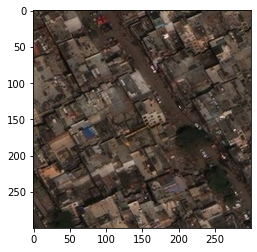

In [6]:
img = Image.fromarray(np.array(img*255, dtype=np.uint8).transpose(1,2,0))
draw = ImageDraw.Draw(img)
for a in ann['boxes']:
    x,y,x2,y2 = a.numpy()
    print( x,y,x2,y2)
    draw.rectangle([x,y,x2,y2])
    
plt.imshow(np.array(img)/255.)

In [7]:
# Load Model

In [8]:
def build_frcnn_model(num_classes):
    # load an detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.min_size=800
    model.max_size=1333
    # RPN parameters
    model.rpn_pre_nms_top_n_train=2000
    model.rpn_pre_nms_top_n_test=1000
    model.rpn_post_nms_top_n_train=2000
    model.rpn_post_nms_top_n_test=1000
    model.rpn_nms_thresh=0.7
    model.rpn_fg_iou_thresh=0.7
    model.rpn_bg_iou_thresh=0.3
    model.rpn_batch_size_per_image=256
    model.rpn_positive_fraction=0.5
    model.rpn_score_thresh=0.0
    # Box parameters
    model.box_score_thresh=0.05
    model.box_nms_thresh=0.5
    model.box_detections_per_img=100
    model.box_fg_iou_thresh=0.5
    model.box_bg_iou_thresh=0.5
    model.box_batch_size_per_image=512
    model.box_positive_fraction=0.25
    return model

    return model

In [9]:
# model = fcos_resnet50_fpn(pretrained=False,num_classes=61)
model=build_frcnn_model(num_classes=61)
model.load_state_dict(torch.load('model_30_ap.pth').state_dict())
_=model.eval()

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
def collate_fn(batch):
    return tuple(list(zip(*batch)))
data_loader_test = torch.utils.data.DataLoader(
        dataset, batch_size=1, sampler=None, num_workers=0, collate_fn=collate_fn)

In [12]:
# images_t, targets_t= list(data_loader_test)[0]

In [11]:
# images_t[0].shape

In [17]:
# from time import time
def visualize_pred(inv_tensor,res):
    '''
    '''
    img = Image.fromarray((255.*inv_tensor.permute((1,2,0)).numpy()).astype(np.uint8))
    draw = ImageDraw.Draw(img)
    for ind,(b,s,l) in enumerate(zip(res[1]['boxes'],res[1]['scores'],res[1]['labels'])):
        # print(b.detach().numpy(), s.detach().numpy())
        x,y,x2,y2 = b.detach().numpy()
        print( x,y,x2,y2,s.item(),l.item())
        draw.rectangle([x,y,x2,y2])
        if ind > 3:
            break

    plt.imshow(img)
def predict(model,images_t):
    '''
    '''
    cpu_device = torch.device('cpu')
    outputs = model(images_t)

    outputss = []
    for t in outputs:
        outputss.append({k: v.to(cpu_device) for k, v in t.items()})
    # model_time = time.time() - model_time
    res = {target["image_id"].item(): output for target, output in zip(targets_t, outputss)}
    visualize_pred(images_t[0],res)
    return img, res

3.51935 0.73095703 63.046425 145.89148 0.5601233839988708 49
21.312927 174.8741 124.57487 271.98547 0.27031442523002625 49


(<PIL.Image.Image image mode=RGB size=300x300>,
 {1: {'boxes': tensor([[  3.5194,   0.7310,  63.0464, 145.8915],
           [ 21.3129, 174.8741, 124.5749, 271.9855]], grad_fn=<StackBackward0>),
   'labels': tensor([49, 49]),
   'scores': tensor([0.5601, 0.2703], grad_fn=<IndexBackward0>)}})

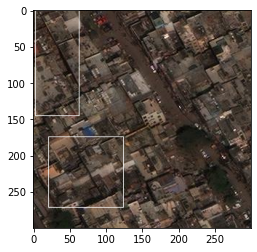

In [18]:
images_t, targets_t= list(data_loader_test)[0]
predict(model,images_t)

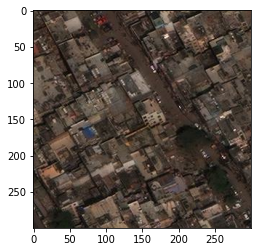

In [19]:
plt.imshow(images_t[0].permute(1,2,0).numpy())

In [21]:

# from torchvision.transforms import transforms
# norm = transforms.Normalize(
#     mean=[0.485, 0.456, 0.406],
#     std=[0.229, 0.224, 0.225]
# )
# n = norm(images_t[0].clone())
# plt.imshow(n.permute(1,2,0).numpy())
# plt.show()
# inv_normalize = transforms.Normalize(
#     mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
#     std=[1/0.229, 1/0.224, 1/0.255]
# )
# # inv_tensor = inv_normalize(tensor)
# inv_tensor = inv_normalize(n.clone())
# plt.imshow(inv_tensor.permute(1,2,0).numpy())
# plt.show()

In [16]:
# i_test = (inv_tensor.permute((1,2,0))).numpy()
# print(i_test.dtype, i_test.mean(), (i_test).mean())
# plt.imshow(i_test)

In [17]:
# npimg = images_t[0].clone().numpy()
# npimg = np.transpose(npimg, (1,2,0))
# npimg = ((npimg * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406])
# print((npimg).mean())
# plt.imshow(npimg, interpolation='nearest')

In [33]:
# img = Image.fromarray(np.array(img*255, dtype=np.uint8).transpose(1,2,0))
# draw = ImageDraw.Draw(img)
# for a in ann['boxes']:
#     x,y,x2,y2 = a.numpy()
#     print( x,y,x2,y2)
#     draw.rectangle([x,y,x2,y2])
    
# plt.imshow(img)

In [34]:
res[1].keys()

dict_keys(['boxes', 'labels', 'scores'])

116.81865 82.031395 165.36769 127.466995 0.8948601484298706 49
287.30096 276.90027 298.52762 289.99857 0.8886122703552246 6
82.90358 6.103775 95.79939 15.845814 0.871465265750885 6
87.63072 10.135021 101.53493 20.325634 0.8643036484718323 6
10.309462 0.15840626 64.80258 47.53177 0.8502728343009949 49


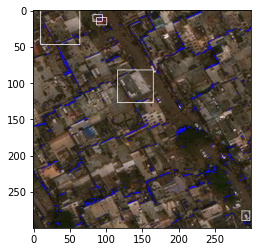

In [38]:
img = Image.fromarray((255.*inv_tensor.permute((1,2,0)).numpy()).astype(np.uint8))
draw = ImageDraw.Draw(img)
for ind,(b,s,l) in enumerate(zip(res[1]['boxes'],res[1]['scores'],res[1]['labels'])):
    # print(b.detach().numpy(), s.detach().numpy())
    x,y,x2,y2 = b.detach().numpy()
    print( x,y,x2,y2,s.item(),l.item())
    draw.rectangle([x,y,x2,y2])
    if ind > 3:
        break
    
plt.imshow(img)

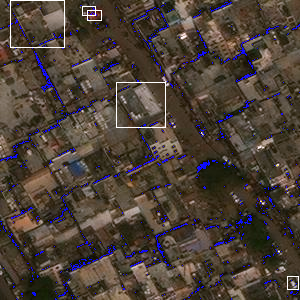

In [39]:
img

3.51935 0.73095703 63.046425 145.89148 0.5601233839988708 49
21.312927 174.8741 124.57487 271.98547 0.27031442523002625 49


(<PIL.Image.Image image mode=RGB size=300x300>,
 {1: {'boxes': tensor([[  3.5194,   0.7310,  63.0464, 145.8915],
           [ 21.3129, 174.8741, 124.5749, 271.9855]], grad_fn=<StackBackward0>),
   'labels': tensor([49, 49]),
   'scores': tensor([0.5601, 0.2703], grad_fn=<IndexBackward0>)}})

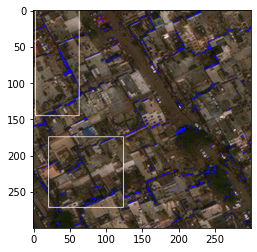

In [20]:
predict(model,images_t)

In [22]:
from torchvision.models.detection.transform import GeneralizedRCNNTransform

In [31]:
transform = GeneralizedRCNNTransform(800, 1333, image_mean, image_std, **kwargs)

NameError: name 'image_mean' is not defined